# **ResNet-50**

![](https://miro.medium.com/v2/resize:fit:1400/0*tH9evuOFqk8F41FG.png)

**IMPORTING NECESSARY LIBRARIES FOR TRAINING OF MODEL**

In [ ]:
#IMPORTING LIBRARIES
import tensorflow
from tensorflow import keras
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix
import numpy as np
import os
from glob import glob
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,AveragePooling2D,Dense,Flatten,ZeroPadding2D,BatchNormalization,Activation,Add,Input,Dropout,GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input


In [ ]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/MyDrive/Rice_Dataset_2/RiceLeafsDisease/train/'
valid_path = '/content/drive/MyDrive/Rice_Dataset_2/RiceLeafsDisease/valid/'
test_path  = '/content/drive/MyDrive/Rice_Dataset_2/RiceLeafsDisease/test/'

In [ ]:
# useful for getting number of output classes
folders = glob('/content/drive/MyDrive/Rice_Dataset_2/RiceLeafsDisease/train/*')
print(len(folders))


4


In [ ]:
pre_model =ResNet50(include_top=False,weights='imagenet',input_shape=[224,224,3],classes=len(folders))

In [ ]:
#Model building
for layer in pre_model.layers:
    layer.trainable = False

pt=Input(shape=[224,224,3])
#The first argument is the shape of input image plus 3(as image is colured[RBG], for black_and_white add 1).
#The second one is the weights equal to imagenet. And, as we know it gives 1000 outputs. Third one excludes the top layer.

func=tensorflow.cast(pt,tensorflow.float32)
x=preprocess_input(func) #This function used to zero-center each color channel wrt Imagenet dataset
model_resnet=pre_model(x,training=False)
model_resnet=GlobalAveragePooling2D()(model_resnet)
model_resnet=Dense(128,activation='relu')(model_resnet)
model_resnet=Dense(64,activation='relu')(model_resnet)
model_resnet=Dense(len(folders),activation='softmax')(model_resnet)


model=Model(inputs=pt,outputs=model_resnet)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast_1 (TFOpLambda)      (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0   

In [ ]:
#Image augmentation
#train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2,
                                 #  horizontal_flip = True,vertical_flip=False,fill_mode='nearest')
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest',
    width_shift_range=0.2,
    height_shift_range=0.2,
    preprocessing_function=preprocess_input)

#valid_datagen = ImageDataGenerator(rescale = 1./255)
#test_datagen = ImageDataGenerator(rescale = 1./255)


valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

 #ImageDataGenerator is used to perform data augmentation on the training images.
 #Data augmentation is a set of techniques to artificial increase the amount of data by generating new data points from existing data.'''
 #The same data augmentation is not applied to the valid images, but they are rescaled by dividing by 255.


training_set = train_datagen.flow_from_directory(train_path,target_size = (224,224), batch_size = 32, class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory(valid_path,target_size = (224,224), batch_size = 32, class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,target_size = (224,224), batch_size = 32, class_mode = 'categorical')

Found 1400 images belonging to 4 classes.
Found 352 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


In [ ]:
#Printing the classes.
class_dict = training_set.class_indices
(class_dict)
li = list(class_dict.keys())
print(li)

['brown_spot', 'healthy', 'hispa', 'leaf_blast']


In [ ]:
#CallBacks
es=EarlyStopping(monitor='val_accuracy',verbose=1,patience=7,mode='auto')
mc=ModelCheckpoint(filepath='/content',monitor='val_accuracy',verbose=1,save_best_only=True)
lr=ReduceLROnPlateau(monitor='val_accuracy',verbose=1,patience=3,min_lr=0.001)

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
#Training
r = model.fit(
  training_set,
  validation_data=valid_set,
  epochs= 50,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)


Epoch 1/50
44/44 [==============================] - 502s 11s/step - loss: 0.9070 - accuracy: 0.6064 - val_loss: 0.5821 - val_accuracy: 0.7812
Epoch 2/50
44/44 [==============================] - 126s 3s/step - loss: 0.5773 - accuracy: 0.7736 - val_loss: 0.5272 - val_accuracy: 0.7926
Epoch 3/50
44/44 [==============================] - 127s 3s/step - loss: 0.4599 - accuracy: 0.8221 - val_loss: 0.6650 - val_accuracy: 0.7642
Epoch 4/50
44/44 [==============================] - 126s 3s/step - loss: 0.4168 - accuracy: 0.8350 - val_loss: 0.5275 - val_accuracy: 0.8011
Epoch 5/50
44/44 [==============================] - 124s 3s/step - loss: 0.3956 - accuracy: 0.8393 - val_loss: 0.4650 - val_accuracy: 0.8182
Epoch 6/50
44/44 [==============================] - 126s 3s/step - loss: 0.3675 - accuracy: 0.8550 - val_loss: 0.4421 - val_accuracy: 0.8182
Epoch 7/50
44/44 [==============================] - 126s 3s/step - loss: 0.3390 - accuracy: 0.8693 - val_loss: 0.4532 - val_accuracy: 0.8381
Epoch 8/50
4

In [ ]:
dir = '/content/gdrive/My Drive/SDP'
model.save(f"{dir}/RESNET50_model.h5")

#model.save("RESNET50_PLANT_DISEASE.h5")

In [ ]:
#Finding the accuracy
print("[INFO] Calculating model accuracy")
scores = model.evaluate(valid_set, batch_size= 32 )
print(f"valid Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
11/11 [==============================] - 21s 2s/step - loss: 0.5643 - accuracy: 0.8494
valid Accuracy: 84.94318127632141


In [ ]:
#Finding the accuracy
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_set, batch_size= 32 )
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
4/4 [==============================] - 33s 10s/step - loss: 1.5901 - accuracy: 0.7250
Test Accuracy: 72.50000238418579


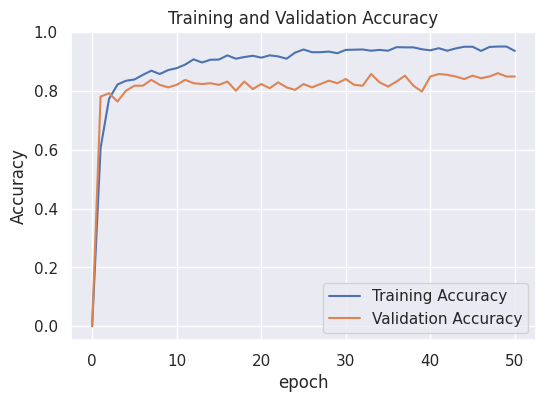

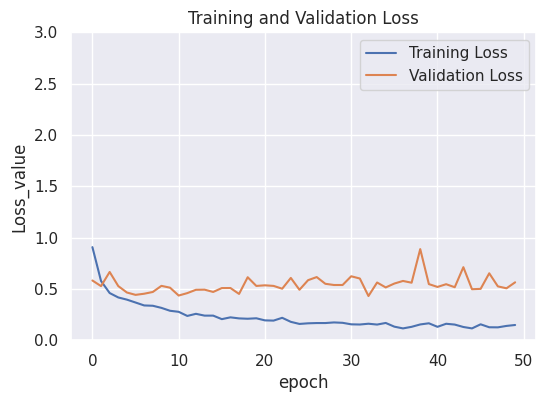

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
acc = [0.] + r.history['accuracy']
val_acc = [0.] + r.history['val_accuracy']

loss = r.history['loss']
val_loss = r.history['val_loss']

plt.figure(figsize=(6, 4))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.savefig('ResNet50_acc')


plt.figure(figsize=(6, 4))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss_value')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('ResNet50_Loss')
plt.show()

4/4 [==============================] - 0s 101ms/step
              precision    recall  f1-score   support

           0       1.00      0.67      0.80        30
           1       0.95      0.67      0.78        30
           2       0.55      0.97      0.70        30
           3       0.69      0.60      0.64        30

    accuracy                           0.73       120
   macro avg       0.80      0.72      0.73       120
weighted avg       0.80      0.72      0.73       120



Text(40.04687499999999, 0.5, 'True Labels')

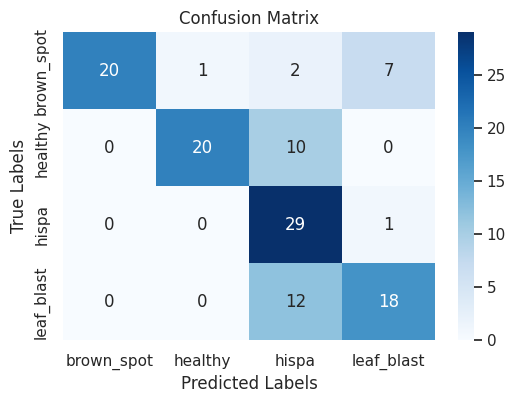

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
# Get the predicted labels for the validation set### Libraries
# Load the trained model
#model = keras.models.load_model("RESNET50_model.h5")

test_step_sz = test_set.n/test_set.batch_size
test_images, test_labels = [], []
for i in np.arange(test_step_sz):
    batch_images, batch_labels = test_set.next()
    test_images.append(batch_images)
    test_labels.append(batch_labels)


test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)



y_pred = model.predict(test_images)
y_pred = np.argmax(y_pred, axis=1)

# Get the true labels for the validation set
y_true = np.argmax(test_labels, axis =1)

# Calculate classification metrics
report = classification_report(y_true, y_pred)
print(report)




# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Get class labels
class_labels = list(valid_set.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")



In [ ]:
# Load the trained model
#model = keras.models.load_model("GoogLeNet_re_model.h5")

# Make predictions on the test images
predictions = model.predict(test_set)

# Get the predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the class names
class_names = training_set.class_indices

# Get the disease labels
disease_labels = {
    0: "Brown_Spot",
    1: "Healthy",
    2: "Hispa",
    3: "Leaf_Blast"
}

# Print the predictions for each test image
for i in range(len(test_set.filenames)):
    image_path = os.path.join(test_path, test_set.filenames[i])
    image_label = predicted_labels[i]
    #image_class = class_names[image_label]
    image_disease = disease_labels[image_label]
    print(f"Image: {image_path}")
    #print(f"Class: {image_class}")
    print(f"Disease: {image_disease}")
    print("----------------------")

4/4 [==============================] - 14s 4s/step
Image: /content/drive/MyDrive/Rice_Dataset_2/RiceLeafsDisease/test/brown_spot/IMG_2992.jpg
Disease: Hispa
----------------------
Image: /content/drive/MyDrive/Rice_Dataset_2/RiceLeafsDisease/test/brown_spot/IMG_3018.jpg
Disease: Brown_Spot
----------------------
Image: /content/drive/MyDrive/Rice_Dataset_2/RiceLeafsDisease/test/brown_spot/IMG_3047.jpg
Disease: Healthy
----------------------
Image: /content/drive/MyDrive/Rice_Dataset_2/RiceLeafsDisease/test/brown_spot/IMG_3048.jpg
Disease: Hispa
----------------------
Image: /content/drive/MyDrive/Rice_Dataset_2/RiceLeafsDisease/test/brown_spot/IMG_3072.jpg
Disease: Hispa
----------------------
Image: /content/drive/MyDrive/Rice_Dataset_2/RiceLeafsDisease/test/brown_spot/IMG_3077.jpg
Disease: Hispa
----------------------
Image: /content/drive/MyDrive/Rice_Dataset_2/RiceLeafsDisease/test/brown_spot/IMG_3091.jpg
Disease: Hispa
----------------------
Image: /content/drive/MyDrive/Rice_Data